## References
- [1] Erlingsson, Pihur, and Korolova (2014) "RAPPOR: Randomized aggregatable privacy-preserving ordinal response" (ACM CCS).
- [2] Arcolezi et al (2022) "Improving the Utility of Locally Differentially Private Protocols for Longitudinal and Multidimensional Frequency Estimates" (Digital Communications and Networks).
- [3] Ding et al (2017) "Collecting telemetry data privately" (NIPS).

In [1]:
frac = 0.05 # (reduced dataset) frac=1 for results in the paper, i.e., whole dataset
nb_seed = 5 # nb_seed=20 for results in the paper

In [2]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'20','xtick.labelsize':'20','ytick.labelsize':'20','font.size':'18', 'legend.fontsize':'medium', 'lines.linewidth':'2.5', 'font.weight':'normal','lines.markersize':'16', 'text.latex.preamble': r'\usepackage{amsfonts}', 'lines.markerfacecolor':'none'}
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from sys import maxsize
import time
import numpy as np
import xxhash
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## Importing protocols

In [3]:
# Seeding function to ensure reproducibility
from LDP.protocols import setting_seed
# Our protocols
from LDP.protocols import LOLOHA_Client, LOLOHA_Aggregator
# Competitors
from LDP.protocols import RAPPOR_Client, RAPPOR_Aggregator # [1]
from LDP.protocols import L_OSUE_Client, L_OSUE_Aggregator # [2]
from LDP.protocols import L_GRR_Client, L_GRR_Aggregator # [2]
from LDP.protocols import dBitFlipPM_Client, dBitFlipPM_Aggregator # [3]

## Reading Synthetic dataset

In [4]:
df = pd.read_csv('datasets/Syn.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,102,56,56,56,56,145,145,145,145,145,...,284,284,260,260,352,352,352,217,120,120
1,348,348,348,348,99,99,99,13,13,13,...,10,10,10,10,10,339,162,162,162,74
2,270,270,265,265,265,265,265,265,265,265,...,154,154,154,154,154,154,154,154,154,154
3,106,106,255,255,255,255,255,255,255,255,...,162,162,162,162,43,43,286,286,109,109
4,71,71,71,71,71,71,71,71,71,71,...,66,66,66,66,232,232,232,232,232,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,167,167,167,167,17,17,17,310,310,310,...,156,156,326,326,326,326,326,312,312,312
9996,299,299,299,299,19,19,19,258,258,258,...,125,125,44,44,138,127,127,127,127,127
9997,217,217,217,313,313,313,168,168,168,168,...,26,26,132,132,132,132,132,132,132,132
9998,221,221,322,322,322,322,218,218,218,218,...,240,240,206,206,206,206,206,185,185,185


## Encoding

In [5]:
LE = LabelEncoder()
LE.fit(np.array([val for col in df.columns for val in df[col]])) # considering all unique values

for col in df.columns:
    df[col] = LE.transform(df[col])

df = df.sample(frac=frac) # to decrease execution time, we'll use frac% of the dataset
df.reset_index(inplace=True, drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,275,275,15,15,289,163,163,28,28,28,...,187,149,149,149,149,123,165,165,65,65
1,212,212,229,229,229,229,163,163,163,163,...,246,240,112,112,112,112,112,112,163,163
2,88,88,88,88,88,88,89,89,89,89,...,20,20,20,153,300,300,113,113,113,113
3,126,126,126,71,188,58,296,296,296,277,...,185,185,185,185,185,99,99,99,99,99
4,327,327,229,229,98,47,47,47,47,158,...,10,10,10,10,10,10,318,318,318,318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,161,161,24,24,24,24,24,169,169,168,...,25,25,246,246,246,246,130,142,142,142
496,303,111,111,111,111,111,111,111,111,111,...,23,23,23,23,335,335,335,335,335,335
497,144,144,144,144,3,3,3,3,3,275,...,160,160,160,160,160,160,160,160,160,160
498,253,253,253,253,64,64,64,64,64,64,...,3,3,3,3,3,3,81,81,81,81


## Static Parameteres

In [6]:
# number of users (n)
n = df.shape[0]
print('Number of Users =',n)

# number of data collections (tau)
tau = df.shape[1]

# attribute's domain size
k = len(LE.classes_)
print("\nAttribute's domain size =", k)

print('\ndBitFlipPM parameters')
b = k
print("Number of bukects b:", b)

bulk_size = k / b
print("Bucket size:", bulk_size)

print("\nPrivacy guarantees:")

# upper bound (infinity reports)
lst_eps_perm = np.arange(0.5, 5.1, 0.5)
print("List of epsilon_perm =", lst_eps_perm)

# alpha value
alpha = 0.4
print("alpha =", alpha)

Number of Users = 500

Attribute's domain size = 360

dBitFlipPM parameters
Number of bukects b: 360
Bucket size: 1.0

Privacy guarantees:
List of epsilon_perm = [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
alpha = 0.4


## Real frequency for each data collection $t \in [\tau]$

In [7]:
dic_real = {t:0 for t in range(tau)}
for t in range(tau):
    real_freq = np.zeros(k)
    for val in df[col].values:
        real_freq[val]+=1
    real_freq = real_freq / sum(real_freq)
    dic_real[t] = real_freq
dic_real

{0: array([0.006, 0.008, 0.004, 0.006, 0.   , 0.006, 0.008, 0.004, 0.004,
        0.004, 0.   , 0.002, 0.004, 0.002, 0.002, 0.   , 0.002, 0.   ,
        0.004, 0.   , 0.002, 0.   , 0.002, 0.   , 0.004, 0.006, 0.01 ,
        0.006, 0.002, 0.006, 0.004, 0.002, 0.   , 0.   , 0.   , 0.   ,
        0.004, 0.006, 0.002, 0.002, 0.008, 0.002, 0.   , 0.   , 0.002,
        0.004, 0.002, 0.008, 0.   , 0.004, 0.004, 0.004, 0.   , 0.006,
        0.006, 0.   , 0.002, 0.002, 0.002, 0.   , 0.002, 0.   , 0.002,
        0.006, 0.002, 0.004, 0.002, 0.01 , 0.002, 0.004, 0.   , 0.   ,
        0.   , 0.006, 0.004, 0.   , 0.002, 0.002, 0.008, 0.004, 0.   ,
        0.002, 0.004, 0.002, 0.   , 0.008, 0.   , 0.004, 0.006, 0.004,
        0.006, 0.002, 0.   , 0.004, 0.002, 0.004, 0.002, 0.002, 0.002,
        0.004, 0.   , 0.004, 0.   , 0.   , 0.   , 0.002, 0.   , 0.   ,
        0.004, 0.002, 0.006, 0.002, 0.   , 0.002, 0.   , 0.   , 0.006,
        0.002, 0.004, 0.002, 0.006, 0.004, 0.008, 0.004, 0.004, 0.01 ,
   

## Take average results due to randomness

In [8]:
# Save MSE per seed
dic_mse = {seed: 
               {"OLOLOHA": [],
                "BiLOLOHA": [],
                "L_OSUE": [],
                "RAPPOR": [],
                "L_GRR": [],
                "1BitFlipPM": [],
                "bBitFlipPM": []
               } 
               for seed in range(nb_seed)
          }
# Save budget consumption per seed
dic_bdg = {seed: 
               {"OLOLOHA": -1,
                "BiLOLOHA": -1,
                "L_OSUE": -1,
                "RAPPOR": -1,
                "L_GRR": -1,
                "1BitFlipPM": -1,
                "bBitFlipPM": -1
               } 
               for seed in range(nb_seed)
          }

# Save data change detection per seed
dic_chg = {seed: 
               {
                "1BitFlipPM": -1,
                "bBitFlipPM": -1
               } 
               for seed in range(nb_seed)
          }

## OLOLOLHA

In [9]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = LOLOHA_Client(row.values, k, eps_perm, eps_1, alpha, optimal=True)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[t] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = LOLOHA_Aggregator(reports[:, t], k, eps_perm, eps_1, alpha, optimal=True)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
    
    dic_mse[seed]["OLOLOHA"] = lst_mse_avg
    dic_bdg[seed]["OLOLOHA"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 3242.9531786441803 seconds


## BiLOLOHA

In [10]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = LOLOHA_Client(row.values, k, eps_perm, eps_1, alpha, optimal=False)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[t] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = LOLOHA_Aggregator(reports[:, t], k, eps_perm, eps_1, alpha, optimal=False)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["BiLOLOHA"] = lst_mse_avg
    dic_bdg[seed]["BiLOLOHA"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 1600.140525341034 seconds


## L-OSUE [2]

In [11]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = L_OSUE_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[t] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = L_OSUE_Aggregator(reports[:, t], eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["L_OSUE"] = lst_mse_avg
    dic_bdg[seed]["L_OSUE"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 54.04503512382507 seconds


## RAPPOR [1]

In [12]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = RAPPOR_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[t] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = RAPPOR_Aggregator(reports[:, t], eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["RAPPOR"] = lst_mse_avg
    dic_bdg[seed]["RAPPOR"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 55.70000624656677 seconds


## L-GRR [2]

In [13]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = L_GRR_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[t] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = L_GRR_Aggregator(reports[:, t], k, eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["L_GRR"] = lst_mse_avg
    dic_bdg[seed]["L_GRR"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 16.339227199554443 seconds


## 1BitFlipPM [3]

In [14]:
starttime = time.time()

# Number of bits each user sample/report
d = 1

for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    lst_detect_change = [] # List of 100% detected change
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        change_tracking = [] # List of Boolean value indicating data change detection for all values
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget, detect_change = dBitFlipPM_Client(row.values, k, b, d, eps_perm)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
            change_tracking.append(detect_change)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = np.zeros(b)
            for val in df[t].values:
                real_freq[int(val / bulk_size)]+=1
            real_freq = real_freq/sum(real_freq)
            
            est_freq = dBitFlipPM_Aggregator(reports[:, t], b, d, eps_perm)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        lst_detect_change.append(100 * sum(change_tracking) / n) # Averaged data change detection in %
        
    dic_mse[seed]["1BitFlipPM"] = lst_mse_avg
    dic_bdg[seed]["1BitFlipPM"] = lst_bdg_avg
    dic_chg[seed]["1BitFlipPM"] = lst_detect_change
    
print('That took {} seconds'.format(time.time() - starttime))

0


KeyError: 0

## bBitFlipPM [3]

In [ ]:
starttime = time.time()

# Number of bits each user sample/report
d = b

for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    lst_detect_change = [] # List of 100% detected change
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        change_tracking = [] # List of Boolean value indicating data change detection for all values
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget, detect_change = dBitFlipPM_Client(row.values, k, b, d, eps_perm)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
            change_tracking.append(detect_change)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = np.zeros(b)
            for val in df[t].values:
                real_freq[int(val / bulk_size)]+=1
            real_freq = real_freq/sum(real_freq)
            
            est_freq = dBitFlipPM_Aggregator(reports[:, t], b, d, eps_perm)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        lst_detect_change.append(100 * sum(change_tracking) / n) # Averaged data change detection in %
        
    dic_mse[seed]["bBitFlipPM"] = lst_mse_avg
    dic_bdg[seed]["bBitFlipPM"] = lst_bdg_avg
    dic_chg[seed]["bBitFlipPM"] = lst_detect_change
    
print('That took {} seconds'.format(time.time() - starttime))

## Plotting MSE_avg metric results

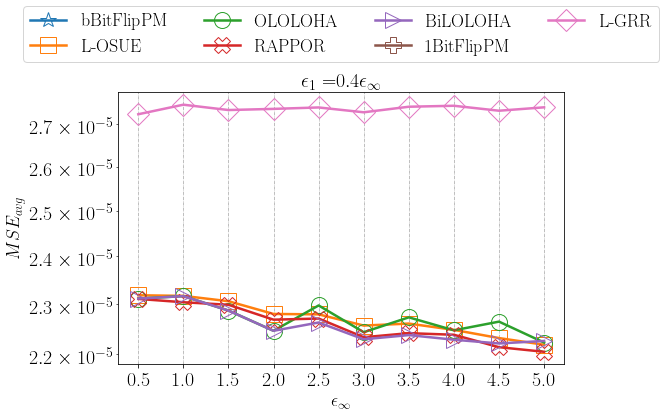

In [15]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_mse[seed]["bBitFlipPM"] for seed in range(nb_seed)], axis=0), label='bBitFlipPM', marker='*')
plt.plot(np.mean([dic_mse[seed]["L_OSUE"] for seed in range(nb_seed)], axis=0), label='L-OSUE',marker='s')
plt.plot(np.mean([dic_mse[seed]["OLOLOHA"] for seed in range(nb_seed)], axis=0), label='OLOLOHA', marker='o')
plt.plot(np.mean([dic_mse[seed]["RAPPOR"] for seed in range(nb_seed)], axis=0), label='RAPPOR',marker='X')
plt.plot(np.mean([dic_mse[seed]["BiLOLOHA"] for seed in range(nb_seed)], axis=0), label='BiLOLOHA',marker='>')
plt.plot(np.mean([dic_mse[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0), label='1BitFlipPM', marker='P')
plt.plot(np.mean([dic_mse[seed]["L_GRR"] for seed in range(nb_seed)], axis=0), label='L-GRR', marker='D')

plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('$MSE_{avg}$')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.title('$\epsilon_1$ $=$' +f'${alpha}$'+ '$\epsilon_{\infty}$', loc='center')
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.show()

## Plotting privacy budget consumption metric results

In [ ]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_bdg[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='dBitFlipPM', marker='P')
plt.plot(np.mean([dic_bdg[seed]["L_OSUE"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='L-OSUE',marker='s')
plt.plot(np.mean([dic_bdg[seed]["OLOLOHA"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='OLOLOHA', marker='o')
plt.plot(np.mean([dic_bdg[seed]["RAPPOR"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='RAPPOR',marker='X')
plt.plot(np.mean([dic_bdg[seed]["BiLOLOHA"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='BiLOLOHA',marker='>')
plt.plot(np.mean([dic_bdg[seed]["L_GRR"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='L-GRR', marker='D', color='tab:pink')


# plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('$\check{\epsilon}_{avg}$')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.title('$\epsilon_1$ $=$' +f'${alpha}$'+ '$\epsilon_{\infty}$', loc='center')
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.show()

## Plotting data change detection for dBitFlipPM

In [ ]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_chg[seed]["bBitFlipPM"] for seed in range(nb_seed)], axis=0), label='bBitFlipPM', marker='*')
plt.plot(np.mean([dic_chg[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0), label='1BitFlipPM', marker='P')
# plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('\% of Users')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.legend(ncol=2)
plt.show()